In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Load Data

In [2]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AAPL = pd.read_csv('AAPL.csv')
AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...,...
2836,2021-04-12,132.520004,132.850006,130.630005,131.240005,131.240005,91420000
2837,2021-04-13,132.440002,134.660004,131.929993,134.429993,134.429993,91266500
2838,2021-04-14,134.940002,135.000000,131.660004,132.029999,132.029999,87222800
2839,2021-04-15,133.820007,135.000000,133.639999,134.500000,134.500000,89347100


In [3]:
def arima_train(start,end,data):
    #Set Date Range
    df_log = np.log(data['Close'][0:start])
    train_data = df_log#[3:int(len(df_log))]
    #Get parameters
    model_autoARIMA = auto_arima(train_data, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        start_P=1, 
                        D=1, 
                        #trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    #Fit Model
    model = ARIMA(train_data, order=model_autoARIMA.order)  
    fitted = model.fit(disp=-1) 
    # Forecast
    fc, se, conf = fitted.forecast(len(AAPL[start:end]), alpha=0.05)  # 95% conf
    return fc

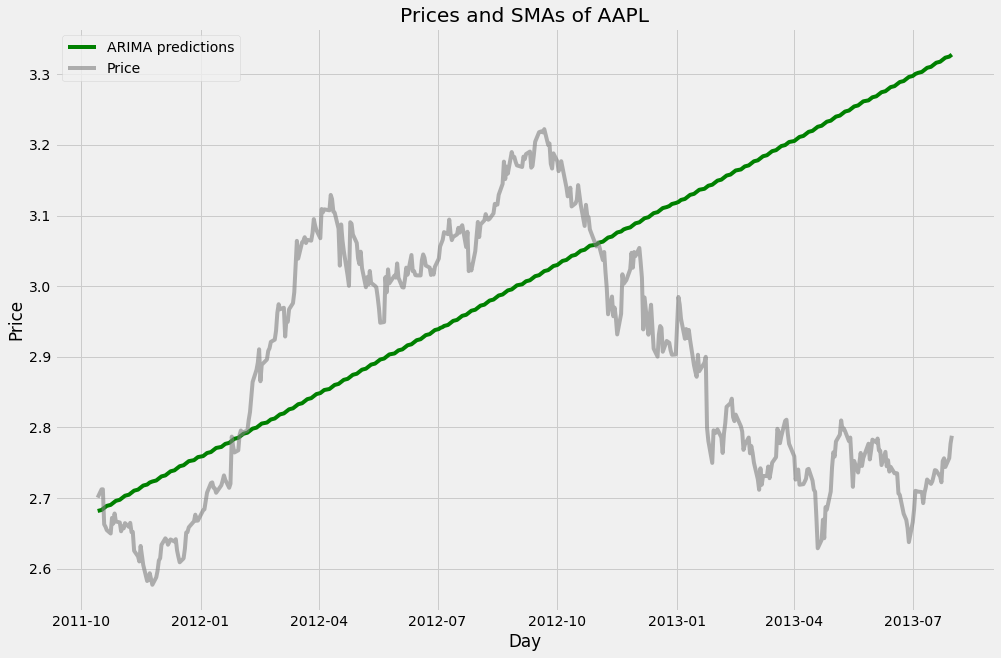

In [4]:
initial_pred = arima_train(450,900,AAPL)

# Visualize ARIMA-pred and prices
plt.figure(figsize=(15,10))
plt.plot(AAPL[['Date']][450:900], initial_pred, label='ARIMA predictions', c='green')
#plt.plot(AAPL[['Date']][450:900], SMA50s[450:900], label='SMA50', c='red')
plt.plot(AAPL[['Date']][450:900], np.log(AAPL[['Open']][450:900]), label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices and SMAs of AAPL')
plt.legend()
plt.show()

### Building The Agent

In [5]:
# Determine when to excecute the strategies
class ARIMA_Agent:
    
    def __init__(self, wallet, pred):
        self.data = None
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.pred_values = pred
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
        
    def ARIMA_func(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.pred_values[index]
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self):
        # first iteration
        arima_pred = ARIMA_Agent.ARIMA_func(self)
        
        # first iteration
        log_price = np.log(self.current_market['Open'])
        #print(arima_pred/log_price)
        if (arima_pred/log_price) != 1:
            #print(arima_pred/log_price)
            if ((arima_pred - log_price) > 0.01) and ARIMA_Agent.can_buy(self,-1):
                #print(arima_pred/log_price)
                # Buy signal
                ARIMA_Agent.buy(self,-1)
            elif ((arima_pred - log_price) < -0.01) and ARIMA_Agent.can_sell(self,-1):
                # sell signal
                ARIMA_Agent.sell(self,-1)
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self, data):
        self.data = data.reset_index()
        for (idx, row) in self.data.iterrows():
            self.current_market = data.iloc[idx]
            ARIMA_Agent.strategy(self)
        return self.history

In [6]:
# Inputs
invest = 1000
start_from = 450
end_from = 900
data = AAPL[start_from:end_from]

pred_values = arima_train(start_from,end_from,AAPL)
agent = ARIMA_Agent(invest,pred_values)
buy_info, sell_info = agent.deploy(data)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 904.9982319999997
Percentage gain: -9.50017680000003 %

Baseline: 9.154810178637618 %


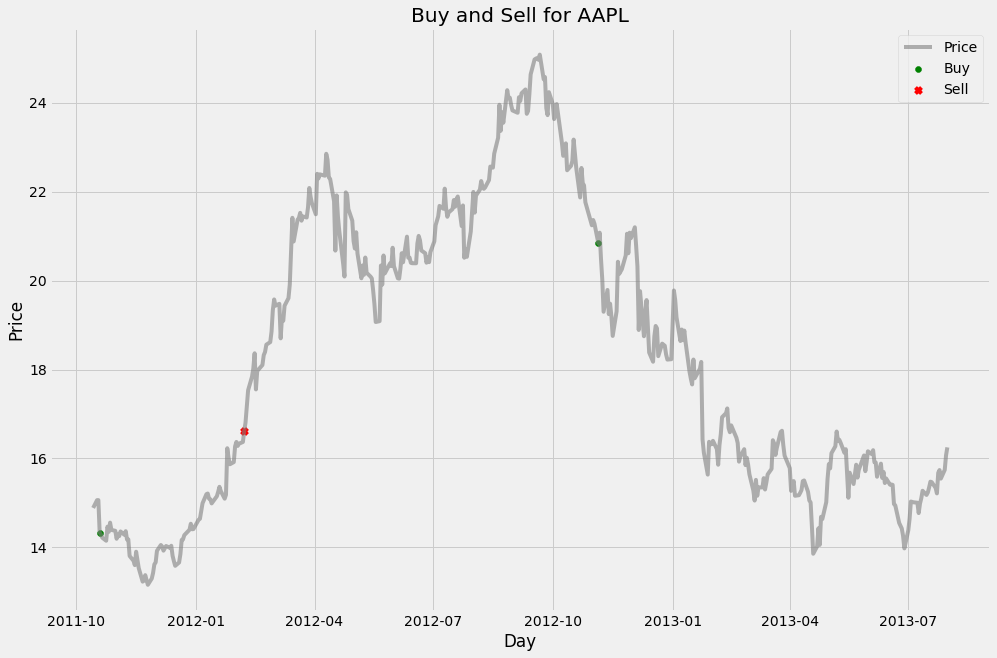

In [7]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

In [8]:
# Inputs
invest = 1000
start_from = 2667
end_from = -1
data = AAPL[start_from:end_from]

pred_values = arima_train(start_from,end_from,AAPL)
agent = ARIMA_Agent(invest,pred_values)
buy_info, sell_info = agent.deploy(data)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1379.7902060000004
Percentage gain: 37.979020600000034 %

Baseline: 18.210330494053608 %


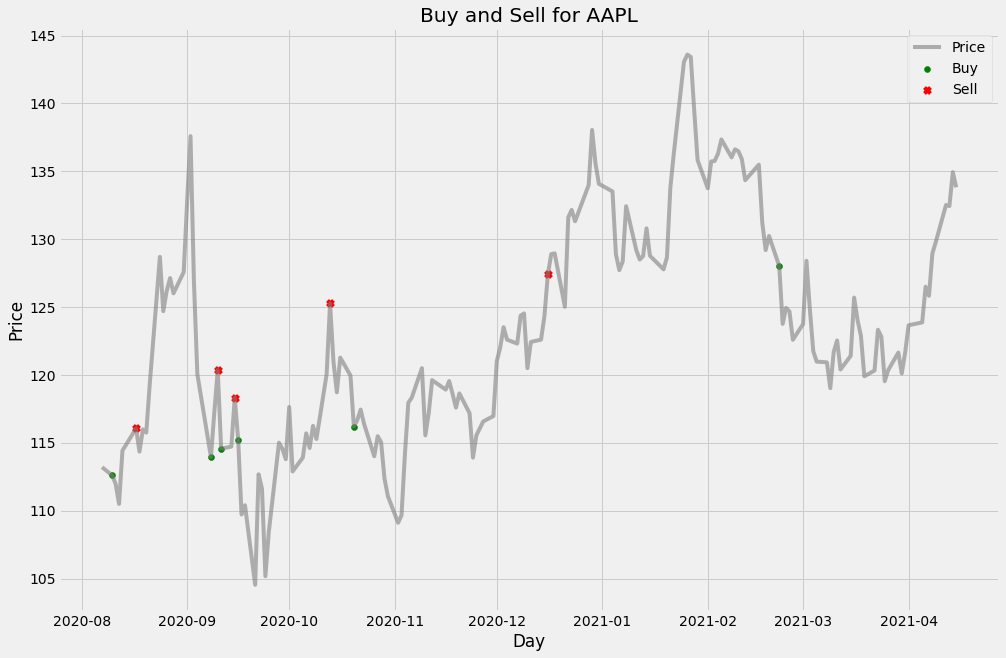

In [9]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

In [10]:
#Calculate RMSE

t1_pred = arima_train(450,900,AAPL)

rmse1 = math.sqrt(mean_squared_error(AAPL['Close'][450:900], t1_pred))
print('RMSE #1: '+str(rmse1))

t2_pred = arima_train(2667,-1,AAPL)

rmse2 = math.sqrt(mean_squared_error(AAPL['Close'][2667:-1], t2_pred))
print('RMSE #2: '+str(rmse2))

RMSE #1: 15.609657126290303
RMSE #2: 118.37111485616289


## Results
- Train until August
- buy or sell with 1% difference
- 37.98% gain over 2667:-1 time period
- Chose KPSS test over ADF test

# Repeat With Amazon Data

In [11]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AMZN = pd.read_csv('AMZN.csv')
AMZN['Date'] = AMZN['Date'].astype('datetime64[ns]')
AMZN

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500
...,...,...,...,...,...,...,...
2836,2021-04-12,3355.209961,3395.040039,3351.149902,3379.389893,3379.389893,3281800
2837,2021-04-13,3400.850098,3432.000000,3395.629883,3400.000000,3400.000000,3315800
2838,2021-04-14,3404.040039,3404.129883,3326.000000,3333.000000,3333.000000,3145200
2839,2021-04-15,3371.000000,3397.000000,3352.000000,3379.090088,3379.090088,3233600


In [12]:
# Inputs
invest = 10000
start_from = 450
end_from = 900
data2 = AMZN[start_from:end_from]

pred_values2 = arima_train(start_from,end_from,AMZN)
agent = ARIMA_Agent(invest,pred_values2)
buy_info, sell_info = agent.deploy(data2)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data2.iloc[-1].Open-data2.iloc[0].Open)/data2.iloc[0].Open, '%')

Invested: 10000
End of day total balance: 13086.539957
Percentage gain: 30.865399570000008 %

Baseline: 26.171798193461164 %


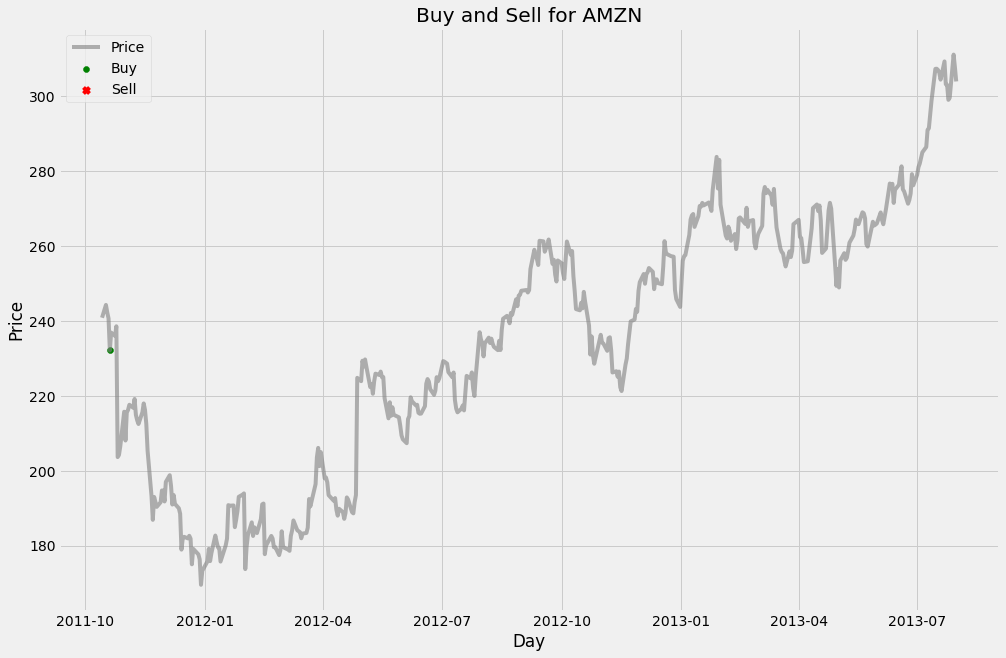

In [13]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data2[['Date']], data2[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AMZN')
plt.legend()
plt.show()

In [14]:
# Inputs
invest = 10000
start_from = 2667
end_from = -1
data2 = AMZN[start_from:end_from]

pred_values = arima_train(start_from,end_from,AMZN)
agent = ARIMA_Agent(invest,pred_values)
buy_info, sell_info = agent.deploy(data2)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data2.iloc[-1].Open-data2.iloc[0].Open)/data2.iloc[0].Open, '%')

Invested: 10000
End of day total balance: 11607.039793
Percentage gain: 16.070397930000002 %

Baseline: 4.559228710335177 %


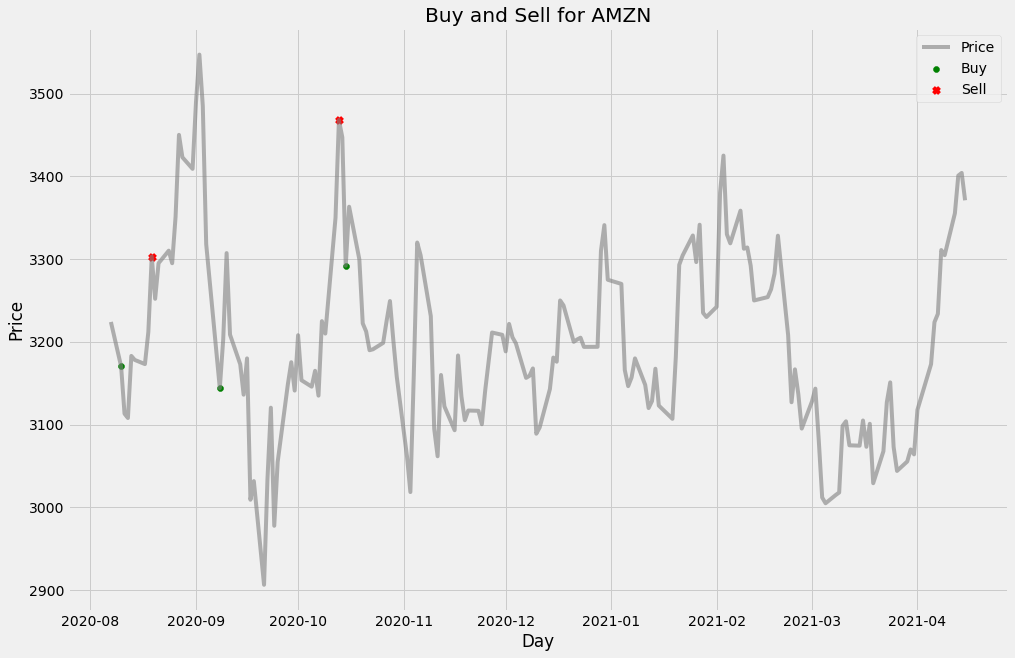

In [16]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data2[['Date']], data2[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AMZN')
plt.legend()
plt.show()

In [17]:
t2_pred = arima_train(2667,-1,AMZN)

rmse2 = math.sqrt(mean_squared_error(AMZN['Close'][2667:-1], t2_pred))
print('RMSE #2: '+str(rmse2))

RMSE #2: 3188.229727931375


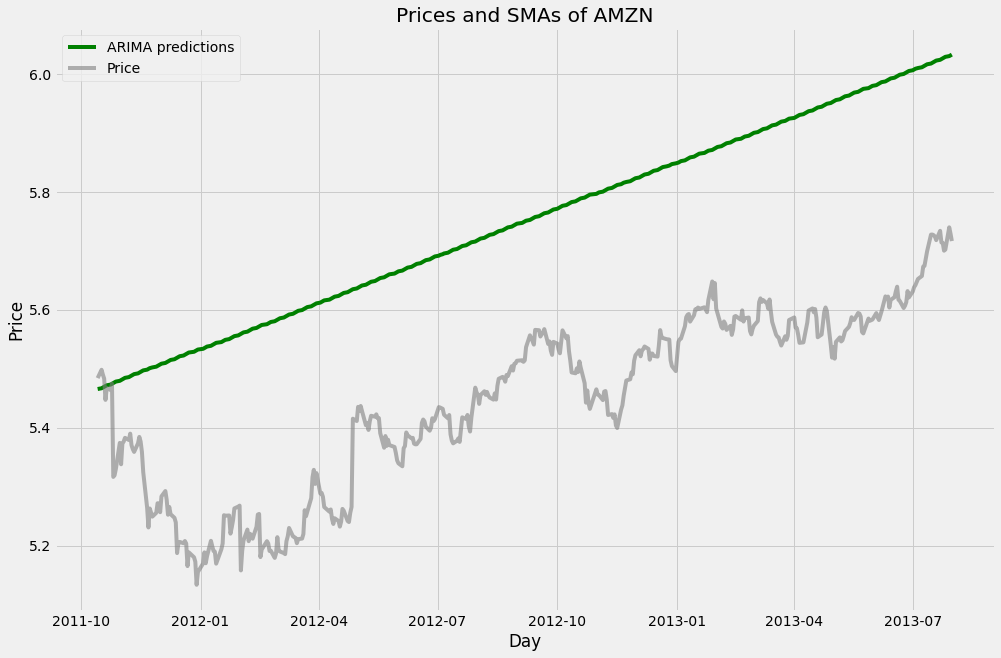

In [18]:
amzn_pred1 = arima_train(450,900,AMZN)

# Visualize ARIMA-pred and prices
plt.figure(figsize=(15,10))
plt.plot(AMZN[['Date']][450:900], amzn_pred1, label='ARIMA predictions', c='green')
#plt.plot(AAPL[['Date']][450:900], SMA50s[450:900], label='SMA50', c='red')
plt.plot(AMZN[['Date']][450:900], np.log(AMZN[['Open']][450:900]), label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices and SMAs of AMZN')
plt.legend()
plt.show()

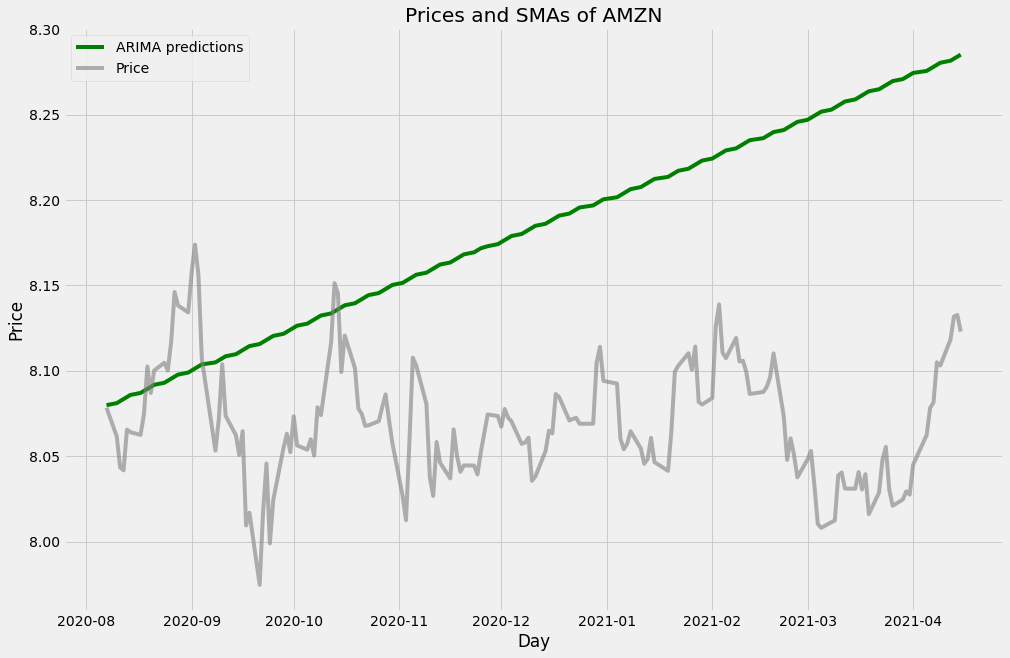

In [19]:
amzn_pred1 = arima_train(2667,-1,AMZN)

# Visualize ARIMA-pred and prices
plt.figure(figsize=(15,10))
plt.plot(AMZN[['Date']][2667:-1], amzn_pred1, label='ARIMA predictions', c='green')
#plt.plot(AAPL[['Date']][450:900], SMA50s[450:900], label='SMA50', c='red')
plt.plot(AMZN[['Date']][2667:-1], np.log(AMZN[['Open']][2667:-1]), label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices and SMAs of AMZN')
plt.legend()
plt.show()

# Repeat With S&P 500

In [20]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
SPY = pd.read_csv('SPY.csv')
SPY['Date'] = SPY['Date'].astype('datetime64[ns]')
SPY

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,90.790062,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
...,...,...,...,...,...,...,...
2836,2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2837,2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2838,2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900
2839,2021-04-15,413.739990,416.160004,413.690002,415.869995,415.869995,60229800


In [21]:
# Inputs
invest = 1000
start_from = 2667
end_from = -1
data3 = SPY[start_from:end_from]

pred_values3 = arima_train(start_from,end_from,SPY)
agent3 = ARIMA_Agent(invest,pred_values3)
buy_info, sell_info = agent3.deploy(data3)

# Check performance
print('Invested:', invest)
print('End of day total balance:', agent3.total_balance())
print('Percentage gain:', 100*(agent3.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data3.iloc[-1].Open-data3.iloc[0].Open)/data3.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1077.8199129999998
Percentage gain: 7.781991299999982 %

Baseline: 24.141860070036767 %


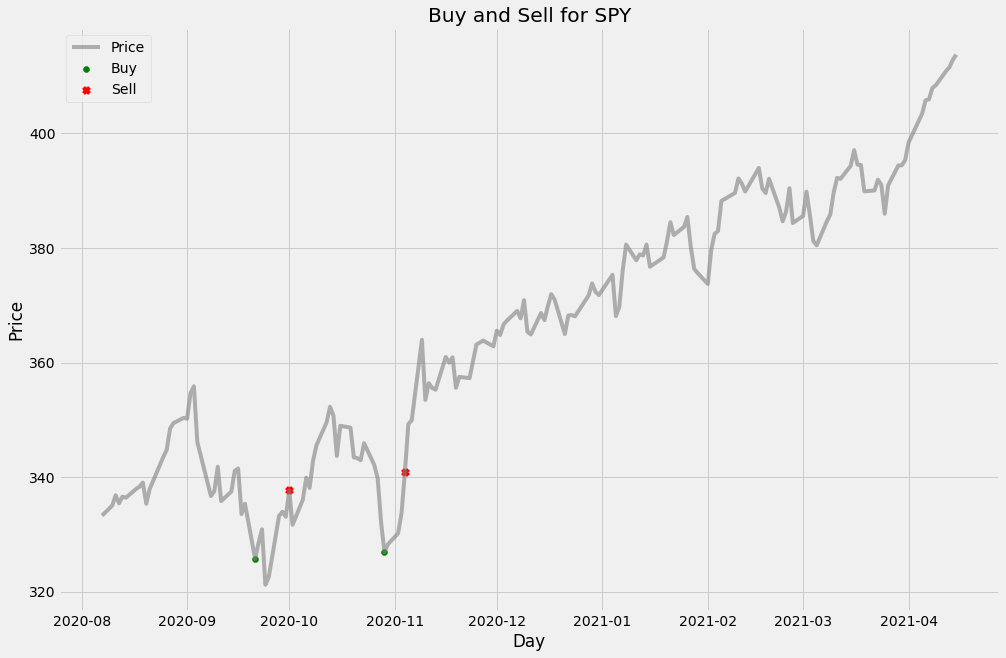

In [22]:
# Visualize and prices
plt.figure(figsize=(15,10))
plt.plot(data3[['Date']], data3[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
#plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for SPY')
plt.legend()
plt.show()

In [23]:
t2_pred = arima_train(2667,-1,SPY)

rmse2 = math.sqrt(mean_squared_error(SPY['Close'][2667:-1], t2_pred))
print('RMSE #2: '+str(rmse2))

RMSE #2: 360.09822648097946


## Results
- 7.78 % gain

In [27]:
AAPL[2667:-1].iloc[0]

Date         2020-08-07 00:00:00
Open                     113.205
High                     113.675
Low                      110.293
Close                    111.113
Adj Close                110.756
Volume                 198045600
Name: 2667, dtype: object

In [29]:
SPY[2667:-1].iloc[0]

Date         2020-08-07 00:00:00
Open                      333.28
High                      334.88
Low                        332.3
Close                     334.57
Adj Close                330.738
Volume                  57308300
Name: 2667, dtype: object

In [30]:
AMZN[2667:-1].iloc[0]

Date         2020-08-07 00:00:00
Open                     3224.01
High                     3240.81
Low                      3140.67
Close                    3167.46
Adj Close                3167.46
Volume                   3936100
Name: 2667, dtype: object